# Repeated experiments with Monte Carlo estimation

In [3]:
import matplotlib.pyplot as plt
from utils import *

torch.manual_seed(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [4]:
num_experiments = 1000


# Parameters
prob_delta = 0.5
num_segments = 6
max_iter = 2000
num_samples = 2048
dims_dense =[1, 16, 64, 16, 1]

list_of_dfs = []

#Distribution

K_intervals = torch.Tensor([[0.5, 1],
                        [3,3]])
nu = NormUnif(x_dim = 2, prob_delta=prob_delta, K_intervals=K_intervals)

middle_point = [0,0]
range_p = [5, 5]

grid_size = 200
xx, yy = torch.meshgrid(torch.linspace((middle_point[0]-range_p[0]), (middle_point[0]+range_p[0]), grid_size), torch.linspace((middle_point[1]-range_p[1]), (middle_point[1]+range_p[1]), grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
import pandas as pd



    
for run_id in tqdm(range(num_experiments)):
    # Creating model
    base = nf.distributions.base.DiagGaussian(2)
    flows = []
    for i in range(num_segments):
        flows += [AffineSingleBlock(SimpleDenseCustDim(dims_dense))]
        flows += [Swap()]

    flows += [ScalingBlock(dim_x = 2)]
    model = MyNormFlow(q0 = base, flows = flows)

    show_iter = int(max_iter/8)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

    # Get training samples
    x_np = nu.forward(num_samples)[0].numpy()
    x = torch.tensor(x_np).float()

    # Training loop
    for it in range(max_iter):
        optimizer.zero_grad()
        
        # Compute loss
        loss = model.forward_kld(x)
        
        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        
    

    
    t_array = np.arange(0, 3.01, 0.1)
    true_probs = []
    probs_x_np = []
    cmc_2048 = []
    cmc_4096 = []
    cmc_10000 = []

    # Calculating true value of P(X>t)
    for t_float in t_array:
        t = torch.tensor(t_float)
        true_probs.append(nu.prob_greater_t(t).item())
        probs_x_np.append(calc_prob_greater_t(samples_np=x_np, t_float=t_float))

    dict_estims = {'t':t_array, 'true_probs':true_probs, 'probs_x_np':probs_x_np}

    for nums_s in [2048, 4096, 10000]:
        cmc_list = []
        strat_list = []
        for t_float in t_array:
            cmc_list.append(estim_prob_greater_t(model, R = nums_s, t_float=t_float))
            samples_strat = generate_samples_from_model_stratified(model, 20000, m=4, n = 2,verbose=False)['samples']
            strat_list.append(calc_prob_greater_t(samples_np=samples_strat, t_float=t_float))
        
        dict_estims[f'cmc_{nums_s}'] = cmc_list.copy()
        dict_estims[f'strat_{nums_s}'] = strat_list.copy()

    estim_df = pd.DataFrame(dict_estims)
    estim_df['run_id'] = run_id
    list_of_dfs.append(estim_df)

100%|██████████| 5/5 [05:05<00:00, 61.15s/it]


In [5]:
main_df = pd.concat(list_of_dfs)

In [6]:
main_df.to_csv('MC_NICE_experiments.csv')

In [7]:
main_df.head()

,t,true_probs,probs_x_np,cmc_2048,strat_2048,cmc_4096,strat_4096,cmc_10000,strat_10000,run_id
0,0.0,0.625000,0.623047,0.590820,0.60810,0.617188,0.61180,0.6113,0.61160,0
1,0.1,0.605879,0.602051,0.573242,0.59615,0.587158,0.59435,0.5964,0.59655,0
2,0.2,0.588511,0.588379,0.581543,0.57670,0.575928,0.57880,0.5798,0.58045,0
3,0.3,0.572996,0.570801,0.569824,0.56890,0.561768,0.56135,0.5611,0.56275,0
4,0.4,0.559367,0.555176,0.556641,0.55000,0.553955,0.55105,0.5489,0.54520,0


In [12]:
means_df = main_df.groupby('t').apply('mean')

In [35]:
means_diff_df = means_df.drop(['run_id', 'true_probs'], axis=1).sub(means_df['true_probs'], axis=0)
means_diff_df

,probs_x_np,cmc_2048,strat_2048,cmc_4096,strat_4096,cmc_10000,strat_10000
t,,,,,,,
0.0,-4.882812e-03,-0.012988,-0.007670,-0.008252,-0.005930,-0.008420,-0.006690
0.1,-5.000281e-03,-0.005391,-0.003729,-0.006563,-0.005439,-0.006619,-0.005789
0.2,-3.452635e-03,-0.004136,-0.005211,-0.008873,-0.003911,-0.006831,-0.003811
0.3,-2.585685e-03,-0.006101,-0.001776,-0.006834,-0.004256,-0.006016,-0.001716
0.4,-3.312373e-03,0.000985,-0.002417,-0.008244,-0.003627,-0.007807,-0.004297
0.5,-2.382863e-03,-0.014199,-0.007728,-0.016543,-0.005148,-0.009958,-0.007888
0.6,-2.373016e-03,-0.011748,0.001403,-0.002471,-0.001077,-0.003487,-0.000637
0.7,-1.130342e-04,0.006625,0.003807,-0.000162,0.005327,-0.003173,0.002717
0.8,-1.894480e-03,0.002500,0.006089,0.004844,0.006439,0.000819,0.004049


In [33]:
main_df.t.unique()
ts_to_show = [0.3, 0.8, 1.3, 1.8]
main_df_hist = main_df[main_df['t'].round(1).isin(ts_to_show)]

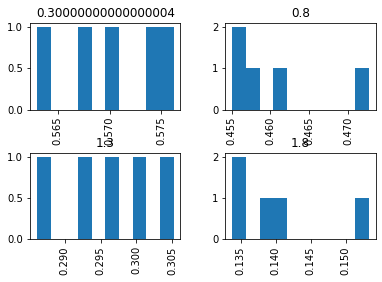

In [34]:
main_df_hist['probs_x_np'].hist(by=main_df_hist['t'])
plt.show()